In [34]:
# This notebook will prepare and process four different correlations:
# 1. A study between number of charge stations in a city against the city's population density
# 2. A study between number of charge stations in a city against the city's gas prices (CA only)
# 3. A study between number of charge stations in a city against the # of McDonald's locations in the city
# 4. A study between number of charge stations in a city against the # of Starbucks locations in the city

# This notebook is widely divided into 3 parts(searchable by "Sec.#"):
# Sec.1: retrieve raw data and clean dataframes
# Sec.2: build working dataframes (including datasource API call)
# Sec.3: plot information

# import utilities
import pandas as pd
import requests
import json
import time
from scipy.stats import linregress
import matplotlib.pyplot as plt
from config import yelpkey
from pprint import pprint
#REMOVE IF NOT USED
import math

# Begin Sec.1: retrieve raw data and clean dataframes

In [2]:
# import charge station cities list for all studies
chargeStationCitiesdf = pd.read_csv("alt_fuel_stations_city_count.csv", encoding = "UTF-8", index_col = 0)
chargeStationCitiesdf.head(3)

,No. of Charge Stations
Unique City,
"ABBOTSFORD, WI",1
"ABERDEEN, MD",6
"ABERDEEN, NJ",1


In [3]:
# import cities list with population density and coordinates for study 1
uscitiesdf = pd.read_csv("uscities.csv", encoding = "UTF-8", index_col = 0)
uscitiesdf.head(3)

,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
city,,,,,,,,,,,,,,,,
New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574.0,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494


In [4]:
# drop necessary columns, prep for merging and execute merge
# pull columns city_ascii, state_id, lat, lng into new dataframe
uscitiesColRemoved = uscitiesdf[["city_ascii","state_id","state_name","lat","lng","population","density"]]
# capitalize city_ascii
uscitiesColRemoved["city_ascii"] = uscitiesColRemoved["city_ascii"].str.upper()
# rename density column for clarification
uscitiesClean = uscitiesColRemoved.rename(columns = {"density":"Density(km^2)"}, copy = True)
# create state-unique city column for merging, combining city name with state ID
uscitiesClean["Unique City"] = uscitiesClean["city_ascii"] + ", " + uscitiesClean["state_id"]
uscitiesClean

<ipython-input-4-b220ae629713>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uscitiesColRemoved["city_ascii"] = uscitiesColRemoved["city_ascii"].str.upper()


,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City
city,,,,,,,,
New York,NEW YORK,NY,New York,40.6943,-73.9249,18713220,10715.0,"NEW YORK, NY"
Los Angeles,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA"
Chicago,CHICAGO,IL,Illinois,41.8373,-87.6862,8604203,4574.0,"CHICAGO, IL"
Miami,MIAMI,FL,Florida,25.7839,-80.2102,6445545,5019.0,"MIAMI, FL"
Dallas,DALLAS,TX,Texas,32.7936,-96.7662,5743938,1526.0,"DALLAS, TX"
...,...,...,...,...,...,...,...,...
Poso Park,POSO PARK,CA,California,35.8114,-118.6364,2,17.0,"POSO PARK, CA"
Lotsee,LOTSEE,OK,Oklahoma,36.1334,-96.2091,2,39.0,"LOTSEE, OK"
The Ranch,THE RANCH,MN,Minnesota,47.3198,-95.6952,2,2.0,"THE RANCH, MN"


In [6]:
# import city landmass list and clean
city_landmass = pd.read_csv("city_landmass.csv", encoding = "ISO-8859-1", index_col = 0)
#pull columns city_ascii, state_id, lat, lng
city_landmassColRemoved = city_landmass[["Unique City","Land Area (sq km)"]]
# change "Land Area (sq km)" to float
city_landmassColRemoved["Land Area (sq km)"] = city_landmassColRemoved["Land Area (sq km)"].str.replace(",","").astype(float)
city_landmassColRemoved["Land Area (sq km)"] = city_landmassColRemoved["Land Area (sq km)"].astype(int)
city_landmassColRemoved

<ipython-input-6-c8feb414f6bf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_landmassColRemoved["Land Area (sq km)"] = city_landmassColRemoved["Land Area (sq km)"].str.replace(",","").astype(float)
<ipython-input-6-c8feb414f6bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_landmassColRemoved["Land Area (sq km)"] = city_landmassColRemoved["Land Area (sq km)"].astype(int)


,Unique City,Land Area (sq km)
Rank,,
1,"NEW YORK, NY",8936
2,"LOS ANGELES, CA",4496
3,"CHICAGO, IL",6326
4,"MIAMI, FL",3208
5,"PHILADELPHIA, PA",5131
...,...,...
493,"CHAMBERSBURG, PA",96
494,"GRANTS PASS, OR",70
495,"NEW BERN, NC",112


In [8]:
# merge city landmass data to new data
uscitiesStationsFinal = pd.merge(uscitiesClean, city_landmassColRemoved, on = "Unique City", how="inner")
print(len(uscitiesStationsFinal))
uscitiesStationsFinal.head(3)

486


,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City,Land Area (sq km)
0,NEW YORK,NY,New York,40.6943,-73.9249,18713220,10715.0,"NEW YORK, NY",8936
1,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA",4496
2,CHICAGO,IL,Illinois,41.8373,-87.6862,8604203,4574.0,"CHICAGO, IL",6326


In [9]:
# import gas prices per CA city and clean for study 2
CAgaspricesdf = pd.read_csv("CA_gas_prices_by_city.csv", encoding = "UTF-8", index_col = 0)
# re-index to pull city names into their own series
CAgaspricesIndexed = CAgaspricesdf.reset_index(drop = False)
# capitalize City
CAgaspricesIndexed["City"] = CAgaspricesIndexed["City"].str.upper()
# add "CA" to match with unique cities in cities dataframe
CAgaspricesIndexed["Unique City"] = CAgaspricesIndexed["City"] + ", CA"
CAgaspricesIndexed.head(3)

,City,Price,Unique City
0,BAKERSFIELD,$3.19,"BAKERSFIELD, CA"
1,CHICO-PARADISE,$3.19,"CHICO-PARADISE, CA"
2,EL CENTRO,$3.19,"EL CENTRO, CA"


# Begin Sec.2: build working dataframes (including datasource API call)

In [28]:
# prepare CA gas prices dataframe
# inner join gas prices and cities list to get a cities list of only CA cities, with their gas prices and the
#charge station count
cacitiesStationsMerge = pd.merge(uscitiesStationsFinal, CAgaspricesIndexed, on = "Unique City", how="inner")
cacitiesStationsFinal = pd.merge(cacitiesStationsMerge, chargeStationCitiesdf, on = "Unique City", how="inner")
cacitiesStationsFinal["Price"] = cacitiesStationsFinal["Price"].str.replace('$', '')
cacitiesStationsFinal["Price"] = cacitiesStationsFinal["Price"].astype(float)
cacitiesStationsFinal.to_csv("cacitiesStations.csv")
cacitiesStationsFinal.head(3)

,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City,Land Area (sq km),City,Price,No. of Charge Stations
0,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA",4496,LOS ANGELES,3.28,759
1,SAN FRANCISCO,CA,California,37.7562,-122.4430,3592294,7256.0,"SAN FRANCISCO, CA",1356,SAN FRANCISCO,3.51,216
2,SAN DIEGO,CA,California,32.8312,-117.1225,3220118,1686.0,"SAN DIEGO, CA",1896,SAN DIEGO,3.28,316


In [16]:
# prepare cities dataframe with population density and restaurant numbers
# merge charge station counts to the cities df as an inner merge
uscitiesStations = pd.merge(uscitiesStationsFinal, chargeStationCitiesdf, on = "Unique City", how="inner")
uscitiesStations["Unique City"] = uscitiesStations["Unique City"].astype(str)
print(len(uscitiesStations))
uscitiesStations.head(3)

454


,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City,Land Area (sq km),No. of Charge Stations
0,NEW YORK,NY,New York,40.6943,-73.9249,18713220,10715.0,"NEW YORK, NY",8936,321
1,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA",4496,759
2,CHICAGO,IL,Illinois,41.8373,-87.6862,8604203,4574.0,"CHICAGO, IL",6326,164


In [17]:
# Yelp API call for studies 3 and 4
# prepare parameters and utility variables
api_key = yelpkey
headers = {"Authorization": "Bearer %s" % api_key}

# list that will be added to the cities dataframe as the final result of the api call
valueList = []

#number of hits per city
valueCount = 0

# offset parameter to be used in the API call when more than 1 results page exists
offset = 0

# search term to be changed between searches
searchTerm = "McDonald's"

# progress utility variables to keep track of pages/counts
pageCounter = 1
searchCompleteVar = False
pageHitCount = 0

# begin loop, looking at each city in cities dataframe
for index, city in uscitiesStations.iterrows():
    # limit queries to 7 requests (highest page number with relevant results found to be 5 pages)
    for x in range (7):
        # sleep to follow API rules
        time.sleep(1)
        # prepare request     
        url = "https://api.yelp.com/v3/businesses/search"
        params = {"term": searchTerm, "location":city["Unique City"], "limit":50, "offset": offset}
        # set up exception handling for the call
        try:
            # make request and turn into json object
            requestObject = requests.get(url, params = params, headers = headers)
            response = json.loads(requestObject.text)
            print()
            print("The status code is {}".format(requestObject.status_code) + " for city: " + city["Unique City"])
            print(requestObject.url)
        except:
            # on call error, break from current city loop and move to next city 
            print()
            print("Invalid results. Moving to next request.")             
            pageHitCount = 0
            break
        # on successfull call with a response
        if requestObject.status_code == 200:
            # search through each businesses' properties for the "name" property and determine 
            #match with search term
            for x in response["businesses"]:               
                if x["name"] == searchTerm:
                    # on a match, add to final hit count and add to number of hits on the current page
                    valueCount += 1
                    pageHitCount += 1
                else:
                    # if the current business does not match the search term, break out of the loop that
                    #searches through this result, and mark that the search for this city is done
                    print("Found item that isn't the search term.")
                    searchCompleteVar = True
                    pageHitCount = 0
                    break
            # check if the search for this city is done. If so, break out of the loop searching for additional
            #pages
            if searchCompleteVar == True:
                searchCompleteVar = False
                print(f'Starting new city query.')
                pageHitCount = 0
                break
            # if the search for the same city is not over yet, move to next page
            pageCounter += 1
            print(f'found {valueCount} stores in total so far')
            print(f'found {pageHitCount} stores just on this page')
            print(f'Moving to page {pageCounter}')
            # add to offset variable to offset API call to the next page
            offset = pageHitCount + offset
            pageHitCount = 0
            # on a non-200 response from server, move on to next city
        else:
            print("Server returned error. Moving to next request")
            pageHitCount = 0
            break
    # add current city's final hit count to the list and reset counters to begin new city search
    valueList.append(valueCount)
    valueCount = 0    
    offset = 0
    pageCounter = 1


The status code is 200 for city: NEW YORK, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=NEW+YORK%2C+NY&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: NEW YORK, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=NEW+YORK%2C+NY&limit=50&offset=50
found 100 stores in total so far
found 50 stores just on this page
Moving to page 3

The status code is 200 for city: NEW YORK, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=NEW+YORK%2C+NY&limit=50&offset=100
found 150 stores in total so far
found 50 stores just on this page
Moving to page 4

The status code is 200 for city: NEW YORK, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=NEW+YORK%2C+NY&limit=50&offset=150
found 200 stores in total so far
found 50 stores just on this page
Moving to page 5

The status code is 200 for city: NEW YORK, NY
https://api.yelp.


The status code is 200 for city: MINNEAPOLIS, MN
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MINNEAPOLIS%2C+MN&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: MINNEAPOLIS, MN
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MINNEAPOLIS%2C+MN&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: TAMPA, FL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=TAMPA%2C+FL&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: TAMPA, FL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=TAMPA%2C+FL&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&loc


The status code is 200 for city: CHARLOTTE, NC
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=CHARLOTTE%2C+NC&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: VIRGINIA BEACH, VA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=VIRGINIA+BEACH%2C+VA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MILWAUKEE, WI
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MILWAUKEE%2C+WI&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: MILWAUKEE, WI
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MILWAUKEE%2C+WI&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: PROVIDENCE, RI
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&


The status code is 200 for city: GRAND RAPIDS, MI
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=GRAND+RAPIDS%2C+MI&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MISSION VIEJO, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MISSION+VIEJO%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ALBANY, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=ALBANY%2C+NY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: KNOXVILLE, TN
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=KNOXVILLE%2C+TN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BAKERSFIELD, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=BAKERSFIELD%2


The status code is 200 for city: KISSIMMEE, FL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=KISSIMMEE%2C+FL&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: FAYETTEVILLE, AR
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=FAYETTEVILLE%2C+AR&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: PENSACOLA, FL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=PENSACOLA%2C+FL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: VICTORVILLE, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=VICTORVILLE%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: LANCASTER, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=LANCASTER%2C


The status code is 200 for city: LAREDO, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=LAREDO%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CONCORD, NC
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=CONCORD%2C+NC&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: COLUMBUS, GA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=COLUMBUS%2C+GA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MCKINNEY, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MCKINNEY%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: KILLEEN, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=KILLEEN%2C+TX&limit=50&offset=0
Found i


The status code is 200 for city: SIOUX FALLS, SD
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=SIOUX+FALLS%2C+SD&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: HUNTINGTON, WV
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=HUNTINGTON%2C+WV&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: HAGERSTOWN, MD
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=HAGERSTOWN%2C+MD&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ERIE, PA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=ERIE%2C+PA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: NAMPA, ID
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=NAMPA%2C+ID&limit=50&offset=0


The status code is 200 for city: TYLER, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=TYLER%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: YUMA, AZ
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=YUMA%2C+AZ&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: COLUMBIA, MO
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=COLUMBIA%2C+MO&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ATHENS, GA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=ATHENS%2C+GA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: SANTA MARIA, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=SANTA+MARIA%2C+CA&limit=50&offset=0
Found item 


The status code is 200 for city: SEASIDE, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=SEASIDE%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ABILENE, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=ABILENE%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BLOOMINGTON, IN
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=BLOOMINGTON%2C+IN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ST. CLOUD, MN
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=ST.+CLOUD%2C+MN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MONROE, LA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MONROE%2C+LA&limit=50&offset=0


The status code is 200 for city: PORTSMOUTH, NH
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=PORTSMOUTH%2C+NH&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: SLIDELL, LA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=SLIDELL%2C+LA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MISSOULA, MT
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=MISSOULA%2C+MT&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: AUBURN, AL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=AUBURN%2C+AL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: RAPID CITY, SD
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=RAPID+CITY%2C+SD&limit=50&offset


The status code is 200 for city: KANKAKEE, IL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=KANKAKEE%2C+IL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: WATSONVILLE, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=WATSONVILLE%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: PORTERVILLE, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=PORTERVILLE%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: DAVIS, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=DAVIS%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CAMARILLO, CA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=CAMARILLO%2C+CA&limit=50&


The status code is 200 for city: DUBUQUE, IA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=DUBUQUE%2C+IA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: VICTORIA, TX
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=VICTORIA%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: SARATOGA SPRINGS, NY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=SARATOGA+SPRINGS%2C+NY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: AMES, IA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=AMES%2C+IA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CASPER, WY
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=CASPER%2C+WY&limit=50&offset


The status code is 200 for city: TITUSVILLE, FL
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=TITUSVILLE%2C+FL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CARTERSVILLE, GA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=CARTERSVILLE%2C+GA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: WALLA WALLA, WA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=WALLA+WALLA%2C+WA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: EAST STROUDSBURG, PA
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&location=EAST+STROUDSBURG%2C+PA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: GOLDSBORO, NC
https://api.yelp.com/v3/businesses/search?term=McDonald%27s&locati

In [18]:
# save results so as not to call to the API unnecessairily
uscitiesStations[f'No. of {searchTerm}'] = valueList
uscitiesStations.to_csv("uscitiesStationFinal.csv")

In [19]:
# repeat yelp search for "Starbucks" (same code as above, except with a new search term)
#Change this term on ln 19

# Yelp API call for studies 3 and 4
# prepare parameters and utility variables
api_key = yelpkey
headers = {"Authorization": "Bearer %s" % api_key}

# list that will be added to the cities dataframe as the final result of the api call
valueList = []

#number of hits per city
valueCount = 0

# offset parameter to be used in the API call when more than 1 results page exists
offset = 0

# search term to be changed between searches
searchTerm = "Starbucks"

# progress utility variables to keep track of pages/counts
pageCounter = 1
searchCompleteVar = False
pageHitCount = 0

# begin loop, looking at each city in cities dataframe
for index, city in uscitiesStations.iterrows():
    # limit queries to 7 requests (highest page number with relevant results found to be 5 pages)
    for x in range (7):
        # sleep to follow API rules
        time.sleep(1)
        # prepare request     
        url = "https://api.yelp.com/v3/businesses/search"
        params = {"term": searchTerm, "location":city["Unique City"], "limit":50, "offset": offset}
        # set up exception handling for the call
        try:
            # make request and turn into json object
            requestObject = requests.get(url, params = params, headers = headers)
            response = json.loads(requestObject.text)
            print()
            print("The status code is {}".format(requestObject.status_code) + " for city: " + city["Unique City"])
            print(requestObject.url)
        except:
            # on call error, break from current city loop and move to next city 
            print()
            print("Invalid results. Moving to next request.")             
            pageHitCount = 0
            break
        # on successfull call with a response
        if requestObject.status_code == 200:
            # search through each businesses' properties for the "name" property and determine 
            #match with search term
            for x in response["businesses"]:               
                if x["name"] == searchTerm:
                    # on a match, add to final hit count and add to number of hits on the current page
                    valueCount += 1
                    pageHitCount += 1
                else:
                    # if the current business does not match the search term, break out of the loop that
                    #searches through this result, and mark that the search for this city is done
                    print("Found item that isn't the search term.")
                    searchCompleteVar = True
                    pageHitCount = 0
                    break
            # check if the search for this city is done. If so, break out of the loop searching for additional
            #pages
            if searchCompleteVar == True:
                searchCompleteVar = False
                print(f'Starting new city query.')
                pageHitCount = 0
                break
            # if the search for the same city is not over yet, move to next page
            pageCounter += 1
            print(f'found {valueCount} stores in total so far')
            print(f'found {pageHitCount} stores just on this page')    
            print(f'Moving to page {pageCounter}')
            # add to offset variable to offset API call to the next page
            offset = pageHitCount + offset
            pageHitCount = 0
        # on a non-200 response from server, move on to next city
        else:
            print("Server returned error. Moving to next request")
            pageHitCount = 0
            break
    # add current city's final hit count to the list and reset counters to begin new city search
    valueList.append(valueCount)
    valueCount = 0    
    offset = 0
    pageCounter = 1


The status code is 200 for city: NEW YORK, NY
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=NEW+YORK%2C+NY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: LOS ANGELES, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=LOS+ANGELES%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CHICAGO, IL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CHICAGO%2C+IL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MIAMI, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MIAMI%2C+FL&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: MIAMI, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MIAMI%2C+FL&limit=50&offset=50
fo


The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DENVER%2C+CO&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DENVER%2C+CO&limit=50&offset=50
found 100 stores in total so far
found 50 stores just on this page
Moving to page 3

The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DENVER%2C+CO&limit=50&offset=100
found 150 stores in total so far
found 50 stores just on this page
Moving to page 4

The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DENVER%2C+CO&limit=50&offset=150
found 200 stores in total so far
found 50 stores just on this page
Moving to page 5

The status code is 200 for city: DENVER, CO
https://api.yelp.com/v3/businesses/search?term=


The status code is 200 for city: COLUMBUS, OH
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=COLUMBUS%2C+OH&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: COLUMBUS, OH
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=COLUMBUS%2C+OH&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CHARLOTTE, NC
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CHARLOTTE%2C+NC&limit=50&offset=0
found 50 stores in total so far
found 50 stores just on this page
Moving to page 2

The status code is 200 for city: CHARLOTTE, NC
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CHARLOTTE%2C+NC&limit=50&offset=50
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: VIRGINIA BEACH, VA
https://api.yelp.com/v3/businesses/search?term=Starbucks&locati


The status code is 200 for city: ALLENTOWN, PA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=ALLENTOWN%2C+PA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: TULSA, OK
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=TULSA%2C+OK&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CAPE CORAL, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CAPE+CORAL%2C+FL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CONCORD, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CONCORD%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: COLORADO SPRINGS, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=COLORADO+SPRINGS%2C+CO&limit=50&offset=0



The status code is 200 for city: SYRACUSE, NY
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=SYRACUSE%2C+NY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: LANCASTER, PA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=LANCASTER%2C+PA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: STOCKTON, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=STOCKTON%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: POUGHKEEPSIE, NY
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=POUGHKEEPSIE%2C+NY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: AUGUSTA, GA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=AUGUSTA%2C+GA&limit=50&offset=0
Found 


The status code is 200 for city: MYRTLE BEACH, SC
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MYRTLE+BEACH%2C+SC&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: EUGENE, OR
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=EUGENE%2C+OR&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CANTON, OH
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CANTON%2C+OH&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: LUBBOCK, TX
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=LUBBOCK%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: READING, PA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=READING%2C+PA&limit=50&offset=0
Found item that is


The status code is 200 for city: SANTA BARBARA, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=SANTA+BARBARA%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: GAINESVILLE, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=GAINESVILLE%2C+FL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: OLYMPIA, WA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=OLYMPIA%2C+WA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: NORWICH, CT
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=NORWICH%2C+CT&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: DELTONA, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DELTONA%2C+FL&limit=50&offset=0
Foun


The status code is 200 for city: MUSKEGON, MI
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MUSKEGON%2C+MI&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MACON, GA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MACON%2C+GA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: NEW BEDFORD, MA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=NEW+BEDFORD%2C+MA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: FAIRFIELD, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=FAIRFIELD%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BINGHAMTON, NY
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=BINGHAMTON%2C+NY&limit=50&offset=0
Found it


The status code is 200 for city: KINGSPORT, TN
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=KINGSPORT%2C+TN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: DULUTH, MN
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DULUTH%2C+MN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ROCK HILL, SC
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=ROCK+HILL%2C+SC&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: GILROY, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=GILROY%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: TEXAS CITY, TX
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=TEXAS+CITY%2C+TX&limit=50&offset=0
Found item tha


The status code is 200 for city: LAFAYETTE, CO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=LAFAYETTE%2C+CO&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: WICHITA FALLS, TX
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=WICHITA+FALLS%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: LAWRENCE, KS
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=LAWRENCE%2C+KS&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BISMARCK, ND
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=BISMARCK%2C+ND&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: MANDEVILLE, LA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MANDEVILLE%2C+LA&limit=50&offset=


The status code is 200 for city: FLORENCE, AL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=FLORENCE%2C+AL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: VALDOSTA, GA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=VALDOSTA%2C+GA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: CHEYENNE, WY
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CHEYENNE%2C+WY&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: KOKOMO, IN
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=KOKOMO%2C+IN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: ST. JOSEPH, MO
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=ST.+JOSEPH%2C+MO&limit=50&offset=0
Found item tha


The status code is 200 for city: MOUNT VERNON, WA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=MOUNT+VERNON%2C+WA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: JANESVILLE, WI
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=JANESVILLE%2C+WI&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: SHERMAN, TX
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=SHERMAN%2C+TX&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BRISTOL, TN
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=BRISTOL%2C+TN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: WEST BEND, WI
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=WEST+BEND%2C+WI&limit=50&offset=0
Foun


The status code is 200 for city: WOODLAND, CA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=WOODLAND%2C+CA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: COLUMBUS, IN
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=COLUMBUS%2C+IN&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BANGOR, ME
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=BANGOR%2C+ME&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: STAUNTON, VA
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=STAUNTON%2C+VA&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: BENTON HARBOR, MI
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=BENTON+HARBOR%2C+MI&limit=50&offset=0
Found it


The status code is 200 for city: CUMBERLAND, MD
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=CUMBERLAND%2C+MD&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: DANVILLE, IL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=DANVILLE%2C+IL&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: PINE BLUFF, AR
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=PINE+BLUFF%2C+AR&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: KAHULUI, HI
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=KAHULUI%2C+HI&limit=50&offset=0
Found item that isn't the search term.
Starting new city query.

The status code is 200 for city: FORT WALTON BEACH, FL
https://api.yelp.com/v3/businesses/search?term=Starbucks&location=FORT+WALTON+BEACH%2C+FL&limit=50

In [21]:
# save results so as not to call to the API unnecessairily
uscitiesStations[f'No. of {searchTerm}'] = valueList
uscitiesStations.to_csv("uscitiesStationFinal.csv")

# Begin Sec.3: plot information

In [24]:
# reload all saved data
uscitiesStationsRead = pd.read_csv("uscitiesStationFinal.csv", encoding = "UTF-8", index_col = 0)
uscitiesStationsRead.head(3)

,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City,Land Area (sq km),No. of Charge Stations,No. of McDonald's,No. of Starbucks
0,NEW YORK,NY,New York,40.6943,-73.9249,18713220,10715.0,"NEW YORK, NY",8936,321,250,47
1,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA",4496,759,203,5
2,CHICAGO,IL,Illinois,41.8373,-87.6862,8604203,4574.0,"CHICAGO, IL",6326,164,16,0


In [29]:
cacitiesStationsRead = pd.read_csv("cacitiesStations.csv", encoding = "UTF-8", index_col = 0)
cacitiesStationsRead.head(3)

,city_ascii,state_id,state_name,lat,lng,population,Density(km^2),Unique City,Land Area (sq km),City,Price,No. of Charge Stations
0,LOS ANGELES,CA,California,34.1139,-118.4068,12750807,3276.0,"LOS ANGELES, CA",4496,LOS ANGELES,3.28,759
1,SAN FRANCISCO,CA,California,37.7562,-122.4430,3592294,7256.0,"SAN FRANCISCO, CA",1356,SAN FRANCISCO,3.51,216
2,SAN DIEGO,CA,California,32.8312,-117.1225,3220118,1686.0,"SAN DIEGO, CA",1896,SAN DIEGO,3.28,316


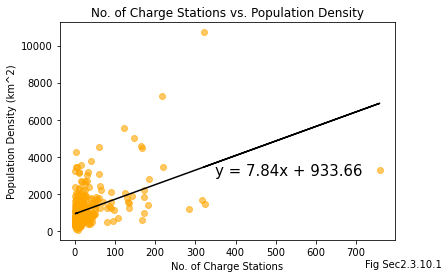

R-squared: 0.219


In [71]:
# population density study
# gather data
popxValues = uscitiesStationsRead["No. of Charge Stations"]
popyValues = uscitiesStationsRead["Density(km^2)"]

# draw plot and labels
(slope, intercept, rvalue, pvalue, stderr) = linregress(popxValues, popyValues)
regress_values = popxValues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(popxValues,popyValues, alpha = 0.60, c = 'orange')

# lable and annotate
plt.plot(popxValues,regress_values,"black")
plt.annotate(line_eq,(350,3000),fontsize = 15,color = "black")
plt.xlabel("No. of Charge Stations")
plt.ylabel("Population Density (km^2)")
plt.title("No. of Charge Stations vs. Population Density")
plt.figtext(.83,.03,"Fig Sec2.3.10.1")
plt.show()

print(f'R-squared: {round(rvalue**2,3)}')


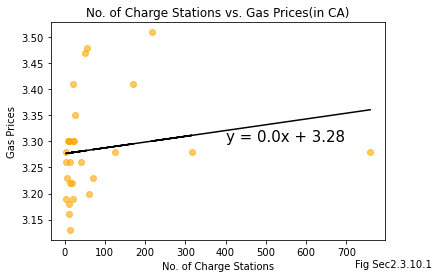

R-squared: 0.031


In [73]:
# CA gas prices study
# gather data
popxValues = cacitiesStationsRead["No. of Charge Stations"]
popyValues = cacitiesStationsRead["Price"]

# draw plot and labels
(slope, intercept, rvalue, pvalue, stderr) = linregress(popxValues, popyValues)
regress_values = popxValues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(popxValues,popyValues, alpha=0.60, c = 'orange')

# lable and annotate
plt.plot(popxValues,regress_values,"black")
plt.annotate(line_eq,(400,3.3),fontsize=15,color="black")
plt.xlabel("No. of Charge Stations")
plt.ylabel("Gas Prices")
plt.title("No. of Charge Stations vs. Gas Prices(in CA)")
plt.figtext(.83,.03,"Fig Sec2.3.10.1")
plt.show()

print(f'R-squared: {round(rvalue**2,3)}')

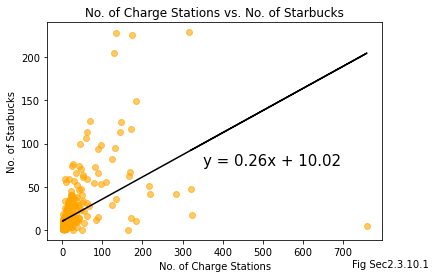

R-squared: 0.239


In [74]:
# population density study
# gather data
popxValues = uscitiesStationsRead["No. of Charge Stations"]
popyValues = uscitiesStationsRead["No. of Starbucks"]

# draw plot and labels
(slope, intercept, rvalue, pvalue, stderr) = linregress(popxValues, popyValues)
regress_values = popxValues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(popxValues,popyValues, alpha=0.60, c = 'orange')

# lable and annotate
plt.plot(popxValues,regress_values,"black")
plt.annotate(line_eq,(350,75),fontsize=15,color = "black")
plt.xlabel("No. of Charge Stations")
plt.ylabel("No. of Starbucks")
plt.title("No. of Charge Stations vs. No. of Starbucks")
plt.figtext(.83,.03,"Fig Sec2.3.10.1")
plt.show()

print(f'R-squared: {round(rvalue**2,3)}')

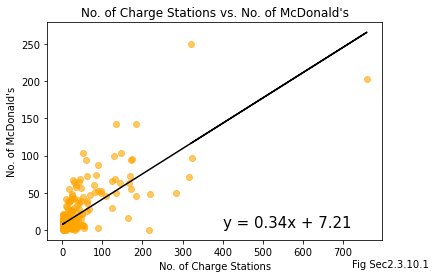

R-squared: 0.582


In [72]:
# population density study
# gather data
popxValues = uscitiesStationsRead["No. of Charge Stations"]
popyValues = uscitiesStationsRead["No. of McDonald's"]

# draw plot and labels
(slope, intercept, rvalue, pvalue, stderr) = linregress(popxValues, popyValues)
regress_values = popxValues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(popxValues,popyValues, alpha = 0.60, c = 'orange')

# lable and annotate
plt.plot(popxValues,regress_values,"black")
plt.annotate(line_eq,(400,3.3),fontsize = 15,color = "black")
plt.xlabel("No. of Charge Stations")
plt.ylabel("No. of McDonald's")
plt.title("No. of Charge Stations vs. No. of McDonald's")
plt.figtext(.83,.03,"Fig Sec2.3.10.1")
plt.show()

print(f'R-squared: {round(rvalue**2,3)}')

In [ ]:
'''
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)


# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)


'''

In [ ]:
'''# IS THIS NECESSARY??? Change to just simple counts for yelp responses?



In [ ]:
'''#calculate radius for Land Area
radiusList = []
for index, row in city_landmassColRemoved.iterrows():
    radiusList.append(math.sqrt(row["Land Area (sq km)"]/math.pi)*1000)
city_landmassColRemoved["radius m"] = radiusList
city_landmassColRemoved["radius m"] = city_landmassColRemoved["radius m"].astype(int)
city_landmassColRemoved'''

In [ ]:
''''''